In [58]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.colors as cl
from matplotlib.colorbar import Colorbar
import seaborn as sns
import pandas as pd
import numpy as np
import glob, joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
# https://mljar.com/blog/save-load-random-forest/

In [2]:
tess_list = glob.glob('./targetdata/*_tess.csv')

tess_data = []

for filename in tess_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    tess_data.append(df)
    
tess_data = pd.concat(tess_data, axis=0, ignore_index=True)

In [3]:
kic = tess_data['KIC']
p_r = tess_data['Santos Period (d)']

ls_a = tess_data['LS Period 1st peak (d)']
ls_b = tess_data['LS Period 2nd peak (d)']
ls_c = tess_data['LS Period 3rd peak (d)']
ls_amp_a = tess_data['LS Period 1st amplitude']
ls_amp_b = tess_data['LS Period 2nd amplitude']
ls_amp_c = tess_data['LS Period 3rd amplitude']
ls_rms_a = tess_data['LS Period 1st RMS']
ls_rms_b = tess_data['LS Period 2nd RMS']
ls_rms_c = tess_data['LS Period 3rd RMS']
ls_mad_a = tess_data['LS Period 1st MAD']
ls_mad_b = tess_data['LS Period 2nd MAD']
ls_mad_c = tess_data['LS Period 3rd MAD']
ls2_a = tess_data['LS 2-term Period 1st peak (d)']
ls2_b = tess_data['LS 2-term Period 2nd peak (d)']
ls2_c = tess_data['LS 2-term Period 3rd peak (d)']
ls2_amp_a = tess_data['LS 2-term Period 1st amplitude']
ls2_amp_b = tess_data['LS 2-term Period 2nd amplitude']
ls2_amp_c = tess_data['LS 2-term Period 3rd amplitude']
ls2_rms_a = tess_data['LS 2-term Period 1st RMS']
ls2_rms_b = tess_data['LS 2-term Period 2nd RMS']
ls2_rms_c = tess_data['LS 2-term Period 3rd RMS']
ls2_mad_a = tess_data['LS 2-term Period 1st MAD']
ls2_mad_b = tess_data['LS 2-term Period 2nd MAD']
ls2_mad_c = tess_data['LS 2-term Period 3rd MAD']
acf_a = tess_data['ACF Period 1st peak (d)']
acf_b = tess_data['ACF Period 2nd peak (d)']
acf_c = tess_data['ACF Period 3rd peak (d)']
acf_amp_a = tess_data['ACF Period 1st amplitude']
acf_amp_b = tess_data['ACF Period 2nd amplitude']
acf_amp_c = tess_data['ACF Period 3rd amplitude']
acf_rms_a = tess_data['ACF Period 1st RMS']
acf_rms_b = tess_data['ACF Period 2nd RMS']
acf_rms_c = tess_data['ACF Period 3rd RMS']
acf_mad_a = tess_data['ACF Period 1st MAD']
acf_mad_b = tess_data['ACF Period 2nd MAD']
acf_mad_c = tess_data['ACF Period 3rd MAD']
ls_med = tess_data['LS median power']
ls2_med = tess_data['LS 2-term median power']
rvar = tess_data['Rvar']
cdpp = tess_data['CDPP']

In [4]:
ts1 = pd.read_csv('S21r_train.csv')
ts2 = pd.read_csv('S21n_train.csv')
training_set = pd.concat([ts1, ts2])
kic_match = training_set['KIC']
kp_match = training_set['Kp']
teff_match = training_set['Teff']
binary_match = training_set['Flag_Binary']
koi_match = training_set['Flag_KOI']
# sph_match = training_set['Sph']

# kic_t_train = kic_match[:np.where(kic_match==max(kic_t))[0][0]+1].reindex(kic_t).index.values
# kp_t = [m for (k, m) in zip(kic_match, kp_match) if k in kic_t.values]
# teff_t = [t for (k, t) in zip(kic_match, teff_match) if k in kic_t.values]
# flag_binary_t = [f for (k, f) in zip(kic_match, binary_match) if k in kic_t.values]
# flag_koi_t = [f for (k, f) in zip(kic_match, koi_match) if k in kic_t.values]
# sph_t = [s for (k, s) in zip(kic_match, sph_match) if k in kic_t.values]

# Vetting for rotation

In [5]:
period_state = [1 if p > 0 else 0 for p in p_r]

In [6]:
features = np.array([ls_a, ls_b, ls_c,
                    ls_amp_a, ls_amp_b, ls_amp_c,
                    ls_rms_a, ls_rms_b, ls_rms_c,
                    ls_mad_a, ls_mad_b, ls_mad_c,
                    ls2_a, ls2_b, ls2_c,
                    ls2_amp_a, ls2_amp_b, ls2_amp_c,
                    ls2_rms_a, ls2_rms_b, ls2_rms_c,
                    ls2_mad_a, ls2_mad_b, ls2_mad_c,
                    acf_a, acf_b, acf_c,
                    acf_amp_a, acf_amp_b, acf_amp_c,
                    acf_rms_a, acf_rms_b, acf_rms_c,
                    acf_mad_a, acf_mad_b, acf_mad_c,
#                     ls_med, rvar, cdpp])#,
                    ls_med, ls2_med, rvar, cdpp])#,
                    #kp_t, teff_t])#, flag_binary_t, flag_koi_t])
feature_names = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                 'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                 'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                 'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                 'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                 'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                 'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                 'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                 'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                 'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                 'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                 'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                  'LS median power', 'Rvar', 'CDPP']#,
                 'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [7]:
features[np.isnan(features)] = 0

In [8]:
forest = RandomForestClassifier(random_state=0)
forest.fit(features.T, period_state)

# classifier = svm.LinearSVC()
# classifier.fit(features.T, period_state)

RandomForestClassifier(random_state=0)

In [9]:
# classifier.get_params()

In [10]:
importances = forest.feature_importances_
# importances = np.abs(classifier.coef_[0])

In [11]:
for i, val in enumerate(importances):
    print(f'{feature_names[i]}: {val:.5f}')

LS Period 1st peak (d): 0.01781
LS Period 2nd peak (d): 0.01864
LS Period 3rd peak (d): 0.02832
LS Period 1st amplitude: 0.06841
LS Period 2nd amplitude: 0.04196
LS Period 3rd amplitude: 0.02622
LS Period 1st RMS: 0.01326
LS Period 2nd RMS: 0.01673
LS Period 3rd RMS: 0.00921
LS Period 1st MAD: 0.01678
LS Period 2nd MAD: 0.00948
LS Period 3rd MAD: 0.00896
LS 2-term Period 1st peak (d): 0.01678
LS 2-term Period 2nd peak (d): 0.02095
LS 2-term Period 3rd peak (d): 0.02448
LS 2-term Period 1st amplitude: 0.06930
LS 2-term Period 2nd amplitude: 0.06169
LS 2-term Period 3rd amplitude: 0.02212
LS 2-term Period 1st RMS: 0.01894
LS 2-term Period 2nd RMS: 0.01153
LS 2-term Period 3rd RMS: 0.00897
LS 2-term Period 1st MAD: 0.01540
LS 2-term Period 2nd MAD: 0.00954
LS 2-term Period 3rd MAD: 0.00906
ACF Period 1st peak (d): 0.01282
ACF Period 2nd peak (d): 0.00803
ACF Period 3rd peak (d): 0.00277
ACF Period 1st amplitude: 0.05925
ACF Period 2nd amplitude: 0.00975
ACF Period 3rd amplitude: 0.00351
A

## Testing

In [12]:
test_list = glob.glob('./testsetdata/*_tess.csv')

test_data = []

for filename in test_list:
    df = pd.read_csv(filename, index_col=None, header=0)
    test_data.append(df)
    
test_data = pd.concat(test_data, axis=0, ignore_index=True)

In [13]:
kic_test = test_data['KIC']
p_r_test = test_data['Santos Period (d)']

ls_a_test = test_data['LS Period 1st peak (d)']
ls_b_test = test_data['LS Period 2nd peak (d)']
ls_c_test = test_data['LS Period 3rd peak (d)']
ls_amp_a_test = test_data['LS Period 1st amplitude']
ls_amp_b_test = test_data['LS Period 2nd amplitude']
ls_amp_c_test = test_data['LS Period 3rd amplitude']
ls_rms_a_test = test_data['LS Period 1st RMS']
ls_rms_b_test = test_data['LS Period 2nd RMS']
ls_rms_c_test = test_data['LS Period 3rd RMS']
ls_mad_a_test = test_data['LS Period 1st MAD']
ls_mad_b_test = test_data['LS Period 2nd MAD']
ls_mad_c_test = test_data['LS Period 3rd MAD']
ls2_a_test = test_data['LS 2-term Period 1st peak (d)']
ls2_b_test = test_data['LS 2-term Period 2nd peak (d)']
ls2_c_test = test_data['LS 2-term Period 3rd peak (d)']
ls2_amp_a_test = test_data['LS 2-term Period 1st amplitude']
ls2_amp_b_test = test_data['LS 2-term Period 2nd amplitude']
ls2_amp_c_test = test_data['LS 2-term Period 3rd amplitude']
ls2_rms_a_test = test_data['LS 2-term Period 1st RMS']
ls2_rms_b_test = test_data['LS 2-term Period 2nd RMS']
ls2_rms_c_test = test_data['LS 2-term Period 3rd RMS']
ls2_mad_a_test = test_data['LS 2-term Period 1st MAD']
ls2_mad_b_test = test_data['LS 2-term Period 2nd MAD']
ls2_mad_c_test = test_data['LS 2-term Period 3rd MAD']
acf_a_test = test_data['ACF Period 1st peak (d)']
acf_b_test = test_data['ACF Period 2nd peak (d)']
acf_c_test = test_data['ACF Period 3rd peak (d)']
acf_amp_a_test = test_data['ACF Period 1st amplitude']
acf_amp_b_test = test_data['ACF Period 2nd amplitude']
acf_amp_c_test = test_data['ACF Period 3rd amplitude']
acf_rms_a_test = test_data['ACF Period 1st RMS']
acf_rms_b_test = test_data['ACF Period 2nd RMS']
acf_rms_c_test = test_data['ACF Period 3rd RMS']
acf_mad_a_test = test_data['ACF Period 1st MAD']
acf_mad_b_test = test_data['ACF Period 2nd MAD']
acf_mad_c_test = test_data['ACF Period 3rd MAD']
ls_med_test = test_data['LS median power']
ls2_med_test = test_data['LS 2-term median power']
rvar_test = test_data['Rvar']
cdpp_test = test_data['CDPP']

In [14]:
tst1 = pd.read_csv('S21r_test.csv')
tst2 = pd.read_csv('S21n_test.csv')
testing_set2 = pd.concat([tst1, tst2])
testing_set2 = testing_set2[~testing_set2.index.duplicated()]
kic_match2 = testing_set2['KIC']
kp_match2 = testing_set2['Kp']
teff_match2 = testing_set2['Teff']
binary_match2 = testing_set2['Flag_Binary']
koi_match2 = testing_set2['Flag_KOI']
# sph_match = training_set['Sph']

In [15]:
# kic_t_temp = kic_match2[:np.where(kic_match2==max(kic_t_test))[0][0]+1].reindex(kic_t_test).index.values
# kp_t_test = [m for (k, m) in zip(kic_match, kp_match) if k in kic_t_test.values]
# teff_t_test = [t for (k, t) in zip(kic_match, teff_match) if k in kic_t_test.values]
# flag_binary_t_test = [f for (k, f) in zip(kic_match, binary_match) if k in kic_t_test.values]
# flag_koi_t_test = [f for (k, f) in zip(kic_match, koi_match) if k in kic_t_test.values]
# sph_t = [s for (k, s) in zip(kic_match, sph_match) if k in kic_t.values]

In [16]:
test_features = np.array([ls_a_test, ls_b_test, ls_c_test,
                    ls_amp_a_test, ls_amp_b_test, ls_amp_c_test,
                    ls_rms_a_test, ls_rms_b_test, ls_rms_c_test,
                    ls_mad_a_test, ls_mad_b_test, ls_mad_c_test,
                    ls2_a_test, ls2_b_test, ls2_c_test,
                    ls2_amp_a_test, ls2_amp_b_test, ls2_amp_c_test,
                    ls2_rms_a_test, ls2_rms_b_test, ls2_rms_c_test,
                    ls2_mad_a_test, ls2_mad_b_test, ls2_mad_c_test,
                    acf_a_test, acf_b_test, acf_c_test,
                    acf_amp_a_test, acf_amp_b_test, acf_amp_c_test,
                    acf_rms_a_test, acf_rms_b_test, acf_rms_c_test,
                    acf_mad_a_test, acf_mad_b_test, acf_mad_c_test,
#                     ls_med_test, rvar_test, cdpp_test])#,
                    ls_med_test, ls2_med_test, rvar_test, cdpp_test])#,
#                     kp_t_test, teff_t_test])#, flag_binary_t_test, flag_koi_t_test])
test_feature_names = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [17]:
test_features[np.isnan(test_features)] = 0

In [18]:
predictions = forest.predict(test_features.T)
# predictions = classifier.predict(test_features.T)

In [59]:
joblib.dump(forest, 'spun.joblib')

['spun.joblib']

In [19]:
period_state_test = [1 if p > 0 else 0 for p in p_r_test]

In [20]:
yy = 0
yn = 0
ny = 0
nn = 0
for p, g in zip(period_state_test, predictions):
    if p == 1 and g == 1:
        yy += 1
    elif p == 1 and g == 0:
        yn += 1
    elif p == 0 and g == 1:
        ny += 1
    elif p == 0 and g == 0:
        nn += 1

In [21]:
print('*** TESSIFY ***')
print('in the testing set:')
print(f'- {(yy+yn)/len(predictions)*100:.2f}% are rotators')
print(f'- {(nn+ny)/len(predictions)*100:.2f}% are non-rotators')
print('RF predicts that:')
print(f'- {(yy+ny)/len(predictions)*100:.2f}% are rotators')
print(f'- {(nn+yn)/len(predictions)*100:.2f}% are non-rotators')
print('for rotators in test set, RF predicts:')
print(f'- {yy/(yy+yn)*100:.2f}% are rotators')
print(f'- {yn/(yy+yn)*100:.2f}% are non-rotators')
print('for non-rotators in test set, RF predicts:')
print(f'- {ny/(ny+nn)*100:.2f}% are rotators')
print(f'- {nn/(ny+nn)*100:.2f}% are non-rotators')

*** TESSIFY ***
in the testing set:
- 34.15% are rotators
- 65.85% are non-rotators
RF predicts that:
- 33.82% are rotators
- 66.18% are non-rotators
for rotators in test set, RF predicts:
- 80.88% are rotators
- 19.12% are non-rotators
for non-rotators in test set, RF predicts:
- 9.40% are rotators
- 90.60% are non-rotators


In [22]:
yyc = 0
ync = 0
for p, g, gtp in zip(period_state_test, predictions, p_r_test):
    if gtp < 27:
        if p == 1 and g == 1:
            yyc += 1
        elif p == 1 and g == 0:
            ync += 1

In [23]:
print('for periods less than a sector in test set, RF predicts:')
print(f'- {yyc/(yyc+ync)*100:.2f}% are rotators')
print(f'- {ync/(yyc+ync)*100:.2f}% are non-rotators')

for periods less than a sector in test set, RF predicts:
- 82.66% are rotators
- 17.34% are non-rotators


In [24]:
testbins = np.arange(5,145,5)
percentage_correct = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_state_test, predictions, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        percentage_correct[i] = count_yes/count

In [25]:
percentage_correct

array([0.8365019 , 0.85671642, 0.87747525, 0.84642857, 0.76184971,
       0.73376623, 0.75914634, 0.7254902 , 0.7195122 , 0.76086957,
       0.61904762, 0.71428571, 0.6       , 1.        , 1.        ,
       0.75      , 0.        , 0.66666667, 1.        , 0.        ,
       0.        , 0.5       , 0.        , 0.5       , 0.        ,
       0.        , 0.        , 1.        ])

In [26]:
testbins = np.arange(5,145,5)
num_correct = np.zeros(len(testbins))
num_total = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_state_test, predictions, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            num_total += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        num_correct[i] = count_yes
    num_total[i] = count

In [27]:
num_correct, num_total

(array([440., 574., 709., 711., 659., 452., 249., 111.,  59.,  35.,  13.,
          5.,   3.,   2.,   1.,   3.,   0.,   2.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.]),
 array([4.985e+03, 4.459e+03, 3.789e+03, 2.981e+03, 2.141e+03, 1.276e+03,
        6.600e+02, 3.320e+02, 1.790e+02, 9.700e+01, 5.100e+01, 3.000e+01,
        2.300e+01, 1.800e+01, 1.600e+01, 1.500e+01, 1.100e+01, 1.000e+01,
        7.000e+00, 6.000e+00, 5.000e+00, 5.000e+00, 3.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]))

# Vetting for period goodness

In [28]:
features_g = np.array([ls_a[p_r>0], ls_b[p_r>0], ls_c[p_r>0],
                    ls_amp_a[p_r>0], ls_amp_b[p_r>0], ls_amp_c[p_r>0],
                    ls_rms_a[p_r>0], ls_rms_b[p_r>0], ls_rms_c[p_r>0],
                    ls_mad_a[p_r>0], ls_mad_b[p_r>0], ls_mad_c[p_r>0],
                    ls2_a[p_r>0], ls2_b[p_r>0], ls2_c[p_r>0],
                    ls2_amp_a[p_r>0], ls2_amp_b[p_r>0], ls2_amp_c[p_r>0],
                    ls2_rms_a[p_r>0], ls2_rms_b[p_r>0], ls2_rms_c[p_r>0],
                    ls2_mad_a[p_r>0], ls2_mad_b[p_r>0], ls2_mad_c[p_r>0],
                    acf_a[p_r>0], acf_b[p_r>0], acf_c[p_r>0],
                    acf_amp_a[p_r>0], acf_amp_b[p_r>0], acf_amp_c[p_r>0],
                    acf_rms_a[p_r>0], acf_rms_b[p_r>0], acf_rms_c[p_r>0],
                    acf_mad_a[p_r>0], acf_mad_b[p_r>0], acf_mad_c[p_r>0],
#                     ls_med[p_r>0], rvar[p_r>0], cdpp[p_r>0]])#,
                    ls_med[p_r>0], ls2_med[p_r>0], rvar[p_r>0], cdpp[p_r>0]])#,
                    #kp_t, teff_t])#, flag_binary_t, flag_koi_t])
feature_names_g = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [29]:
tol = 0.1
period_goodness = [1 if l > p-p*tol and l < p+p*tol else 0 for p, l in zip(p_r[p_r>0], ls2_a[p_r>0])]

In [30]:
features_g[np.isnan(features_g)] = 0

In [31]:
forest_g = RandomForestClassifier(random_state=0)
forest_g.fit(features_g.T, period_goodness)

RandomForestClassifier(random_state=0)

In [60]:
joblib.dump(forest_g, 'periods.joblib')

['periods.joblib']

In [32]:
importances_g = forest_g.feature_importances_

In [33]:
for i, val in enumerate(importances_g):
    print(f'{feature_names_g[i]}: {val:.5f}')

LS Period 1st peak (d): 0.03475
LS Period 2nd peak (d): 0.02300
LS Period 3rd peak (d): 0.01987
LS Period 1st amplitude: 0.02799
LS Period 2nd amplitude: 0.02486
LS Period 3rd amplitude: 0.02171
LS Period 1st RMS: 0.02277
LS Period 2nd RMS: 0.01590
LS Period 3rd RMS: 0.01317
LS Period 1st MAD: 0.04285
LS Period 2nd MAD: 0.01950
LS Period 3rd MAD: 0.01569
LS 2-term Period 1st peak (d): 0.07222
LS 2-term Period 2nd peak (d): 0.02876
LS 2-term Period 3rd peak (d): 0.02093
LS 2-term Period 1st amplitude: 0.07123
LS 2-term Period 2nd amplitude: 0.04291
LS 2-term Period 3rd amplitude: 0.02520
LS 2-term Period 1st RMS: 0.02311
LS 2-term Period 2nd RMS: 0.01722
LS 2-term Period 3rd RMS: 0.02411
LS 2-term Period 1st MAD: 0.03531
LS 2-term Period 2nd MAD: 0.01694
LS 2-term Period 3rd MAD: 0.01413
ACF Period 1st peak (d): 0.02224
ACF Period 2nd peak (d): 0.01370
ACF Period 3rd peak (d): 0.00367
ACF Period 1st amplitude: 0.02273
ACF Period 2nd amplitude: 0.01617
ACF Period 3rd amplitude: 0.00449
A

## Testing

In [34]:
test_features_g = np.array([ls_a_test, ls_b_test, ls_c_test,
                    ls_amp_a_test, ls_amp_b_test, ls_amp_c_test,
                    ls_rms_a_test, ls_rms_b_test, ls_rms_c_test,
                    ls_mad_a_test, ls_mad_b_test, ls_mad_c_test,
                    ls2_a_test, ls2_b_test, ls2_c_test,
                    ls2_amp_a_test, ls2_amp_b_test, ls2_amp_c_test,
                    ls2_rms_a_test, ls2_rms_b_test, ls2_rms_c_test,
                    ls2_mad_a_test, ls2_mad_b_test, ls2_mad_c_test,
                    acf_a_test, acf_b_test, acf_c_test,
                    acf_amp_a_test, acf_amp_b_test, acf_amp_c_test,
                    acf_rms_a_test, acf_rms_b_test, acf_rms_c_test,
                    acf_mad_a_test, acf_mad_b_test, acf_mad_c_test,
#                     ls_med_test, rvar_test, cdpp_test])#,
                    ls_med_test, ls2_med_test, rvar_test, cdpp_test])#,
#                     kp_t_test, teff_t_test])#, flag_binary_t_test, flag_koi_t_test])
test_feature_names_g = ['LS Period 1st peak (d)', 'LS Period 2nd peak (d)', 'LS Period 3rd peak (d)',
                     'LS Period 1st amplitude', 'LS Period 2nd amplitude', 'LS Period 3rd amplitude',
                     'LS Period 1st RMS', 'LS Period 2nd RMS', 'LS Period 3rd RMS',
                     'LS Period 1st MAD', 'LS Period 2nd MAD', 'LS Period 3rd MAD',
                     'LS 2-term Period 1st peak (d)', 'LS 2-term Period 2nd peak (d)', 'LS 2-term Period 3rd peak (d)',
                     'LS 2-term Period 1st amplitude', 'LS 2-term Period 2nd amplitude', 'LS 2-term Period 3rd amplitude',
                     'LS 2-term Period 1st RMS', 'LS 2-term Period 2nd RMS', 'LS 2-term Period 3rd RMS',
                     'LS 2-term Period 1st MAD', 'LS 2-term Period 2nd MAD', 'LS 2-term Period 3rd MAD',
                     'ACF Period 1st peak (d)', 'ACF Period 2nd peak (d)', 'ACF Period 3rd peak (d)',
                     'ACF Period 1st amplitude', 'ACF Period 2nd amplitude', 'ACF Period 3rd amplitude',
                     'ACF Period 1st RMS', 'ACF Period 2nd RMS', 'ACF Period 3rd RMS',
                     'ACF Period 1st MAD', 'ACF Period 2nd MAD', 'ACF Period 3rd MAD',
#                      'LS median power', 'Rvar', 'CDPP']#,
                     'LS median power', 'LS 2-term median power', 'Rvar', 'CDPP']#,
#                  'Kp', 'Teff']#, 'Binary flag', 'KOI flag']

In [35]:
test_features_g[np.isnan(test_features_g)] = 0

In [36]:
predictions_g = forest_g.predict(test_features_g.T)

In [37]:
tol = 0.1
period_goodness_test = [1 if l > p-p*tol and l < p+p*tol else 0 for p, l in zip(p_r_test, ls2_a_test)]

In [38]:
yes_good = 0
yes_bad = 0
no_good = 0
no_bad = 0

for good, gtp in zip(predictions_g, p_r_test):
    if gtp > 0 and good == 1:
        yes_good += 1
    elif gtp > 0 and good == 0:
        yes_bad += 1
    elif gtp == 0 and good == 1:
        no_good += 1
    elif gtp == 0 and good == 0:
        no_bad += 1

In [39]:
print(f'{yes_good/(yes_good+yes_bad)*100:.2f}% of rotators are good')
print(f'{no_good/(no_good+no_bad)*100:.2f}% of nonrotators are good')

39.24% of rotators are good
4.98% of nonrotators are good


In [40]:
yy = 0
yn = 0
ny = 0
nn = 0
for p, g in zip(period_goodness_test, predictions_g):
    if p == 1 and g == 1:
        yy += 1
    elif p == 1 and g == 0:
        yn += 1
    elif p == 0 and g == 1:
        ny += 1
    elif p == 0 and g == 0:
        nn += 1

In [41]:
print('*** TESSIFY ***')
print('in the testing set:')
print(f'- {(yy+yn)/len(predictions_g)*100:.2f}% have good periods')
print(f'- {(nn+ny)/len(predictions_g)*100:.2f}% have periods outside 10%')
print('RF predicts that:')
print(f'- {(yy+ny)/len(predictions_g)*100:.2f}% have good periods')
print(f'- {(nn+yn)/len(predictions_g)*100:.2f}% have bad periods')
print('for good periods in test set, RF predicts:')
print(f'- {yy/(yy+yn)*100:.2f}% have good periods')
print(f'- {yn/(yy+yn)*100:.2f}% have bad periods')
print('for bad periods in test set, RF predicts:')
print(f'- {ny/(ny+nn)*100:.2f}% have good periods')
print(f'- {nn/(ny+nn)*100:.2f}% have bad periods')

*** TESSIFY ***
in the testing set:
- 14.28% have good periods
- 85.72% have periods outside 10%
RF predicts that:
- 16.68% have good periods
- 83.32% have bad periods
for good periods in test set, RF predicts:
- 88.97% have good periods
- 11.03% have bad periods
for bad periods in test set, RF predicts:
- 4.64% have good periods
- 95.36% have bad periods


In [42]:
testbins = np.arange(5,145,5)
percentage_correct_g = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        percentage_correct_g[i] = count_yes/count

In [43]:
percentage_correct_g

array([0.60076046, 0.56567164, 0.58044554, 0.51547619, 0.32947977,
       0.10227273, 0.02743902, 0.0130719 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

In [44]:
testbins = np.arange(5,145,5)
num_correct_g = np.zeros(len(testbins))
num_total_g = np.zeros(len(testbins))

for i, b in enumerate(testbins):
    
    b1 = b-5
    b2 = b
    count = 0
    count_yes = 0
    
    for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
        if gtp > b1 and gtp <= b2:
            count += 1
            num_total += 1
            if g == 1:
                count_yes += 1
    
    if count > 0:
        num_correct_g[i] = count_yes
    num_total_g[i] = count

In [45]:
num_correct_g, num_total_g

(array([316., 379., 469., 433., 285.,  63.,   9.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([526., 670., 808., 840., 865., 616., 328., 153.,  82.,  46.,  21.,
          7.,   5.,   2.,   1.,   4.,   1.,   3.,   1.,   1.,   0.,   2.,
          0.,   2.,   0.,   0.,   0.,   1.]))

In [46]:
yyc = 0
ync = 0
for p, g, gtp in zip(period_goodness_test, predictions_g, p_r_test):
    if gtp < 27:
        if p == 1 and g == 1:
            yyc += 1
        elif p == 1 and g == 0:
            ync += 1

In [47]:
print('for periods less than a sector in test set, RF predicts:')
print(f'- {yyc/(yyc+ync)*100:.2f}% are good')
print(f'- {ync/(yyc+ync)*100:.2f}% are bad')

for periods less than a sector in test set, RF predicts:
- 89.09% are good
- 10.91% are bad


## Some plots

<IPython.core.display.Javascript object>


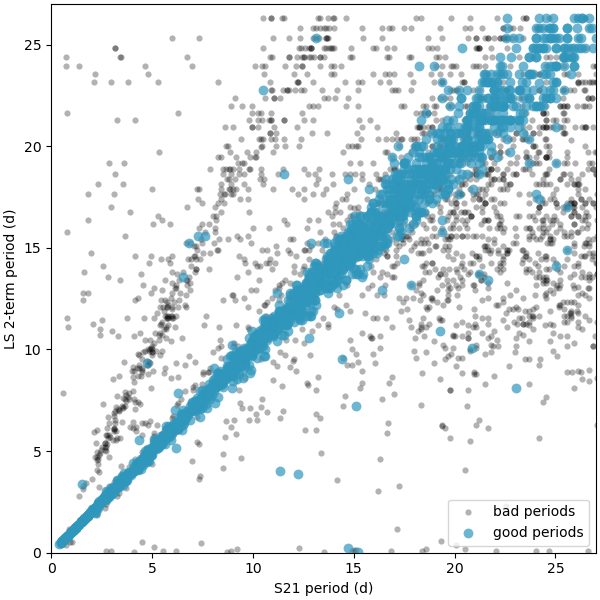

In [56]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[(predictions_g==0)&(p_r_test>0)], ls2_a_test[(predictions_g==0)&(p_r_test>0)], 
           c='#000', alpha=0.3, s=20, lw=0, label='bad periods')
ax.scatter(p_r_test[(predictions_g==1)&(p_r_test>0)], ls2_a_test[(predictions_g==1)&(p_r_test>0)], 
           c='#2f96bc', alpha=0.7, s=50, lw=0, label='good periods')
ax.set(xlim=(0, 27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

<IPython.core.display.Javascript object>


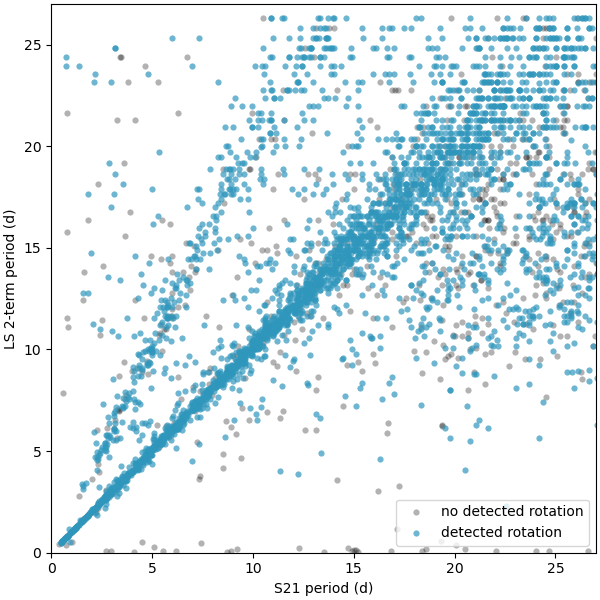

In [55]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[(predictions==0)&(p_r_test>0)], ls2_a_test[(predictions==0)&(p_r_test>0)], 
           c='k', alpha=0.3, s=20, lw=0, label='no detected rotation')
ax.scatter(p_r_test[(predictions==1)&(p_r_test>0)], ls2_a_test[(predictions==1)&(p_r_test>0)], 
           c='#2f96bc', alpha=0.7, s=20, lw=0, label='detected rotation')
ax.set(xlim=(0, 27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

<IPython.core.display.Javascript object>


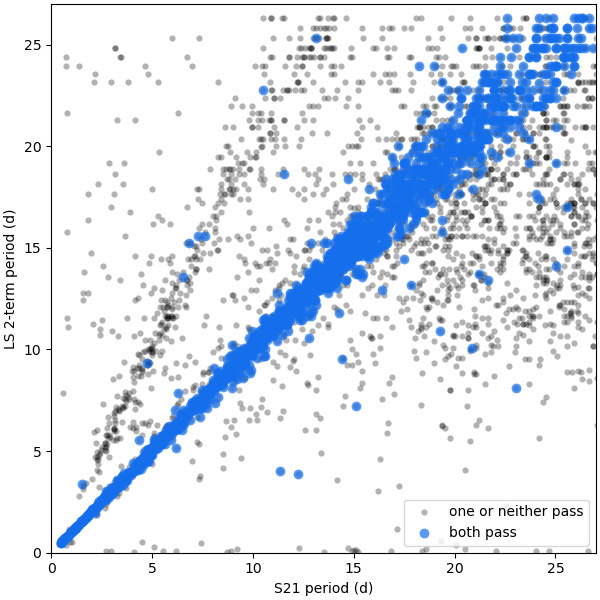

In [54]:
%matplotlib notebook

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(6,6))

ax.scatter(p_r_test[p_r_test>0], ls2_a_test[p_r_test>0], c='k', alpha=0.3, s=20, lw=0, label='one or neither pass')
ax.scatter(p_r_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)], 
           ls2_a_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)], c='#156fed', alpha=0.7, s=50, lw=0, 
           label='both pass')
ax.set(xlim=(0,27), ylim=(0,27), xlabel='S21 period (d)', ylabel='LS 2-term period (d)')
ax.legend(loc='lower right')

In [51]:
len(p_r_test[(predictions==1)&(predictions_g==1)])/len(p_r_test)

0.13749400561759265

In [52]:
len(p_r_test[(predictions==1)&(predictions_g==1)&(p_r_test>0)])/len(p_r_test)

0.12495718298280468

In [53]:
0.1252997191203672 / 0.13797355621018018

0.9081429990069513